# Réseaux de neurones : Echo State Network

## Une brève introduction

<p style="text-align:justify">Depuis l'élaboration du perceptron par Frank Rosenblatt en 1957, de nombreux modèles de réseaux de neurones ont émergé. Un <b>echo state network</b> est un réseau de neurones récurrents (c'est-à-dire dont la trajectoire n'est pas forcément linéaire, et donc possédant une mémoire) dont le réservoir est composé de neurones entre lesquels les poids sont générés aléatoirement. Seuls les poids des sorties (donc entre le réservoir et la sortie) peuvent être modifiés, via un apprentissage supervisé : on va comparer la sortie du réseau avec une sortie « cible ». Nous allons ici développer un modèle d'ESN, issu d'un article de Mantas Lukoševičius.</p>

In [1]:
%matplotlib inline

## Importation des modules

<p style="text-align:justify">Commençons par importer les modules dont nous avons besoin. Outre la commande <b>%matplotlib inline</b> qui permet d'afficher les courbes directement dans le notebook, nous allons avoir besoin de <b>numpy</b> (module numérique destiné à la manipulation de vecteurs et de matrices), de <b>matplotlib</b> (pour tracer les courbes, donc), de <b>scipy</b> (la méthode linalg nous permettra d'importer des fonctions d'algèbre linéaire), ainsi que de widgets issus de <b>IPython</b>, qui nous permettront de rendre les courbes interactives à l'aide de curseurs permettant de modifier les variables en temps réel.</p>

In [2]:
# -*- coding: utf-8 -*-
"""
A minimalistic Echo State Networks demo with Mackey-Glass (delay 17) data 
in "plain" scientific Python.
by Mantas Lukoševičius 2012
http://minds.jacobs-university.de/mantas
---
Modified by Xavier Hinaut: 2015-2016
http://www.xavierhinaut.com
"""
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from ipywidgets import *
from IPython.display import *

## Remise à zéro de l'aléatoire

Ensuite, on va initier une première valeur pseudo-aléatoire en fonction du moment auquel est lancé le programme. Cela permet de s'assurer que deux exécutions du programme ne donneront pas le même résultat.

In [3]:
def set_seed(seed=None):
    """Making the seed (for random values) variable if None"""

    if seed is None:
        import time
        seed = int((time.time()*10**6) % 4294967295)
        print(seed)
    try:
        np.random.seed(seed)
        print("Seed used for random values:", seed)
    except:
        print("!!! WARNING !!!: Seed was not set correctly.")
    return seed

## Création d'une classe "Réseau" et définition des paramètres par défaut

<p style="text-align:justify">On crée une classe <i>Réseau</i>. Un objet appartenant à cette classe contiendra, par défaut, quatre attributs :
<ul><li><b>initLen</b> : nombre d'itérations pour l'initalisation. Durant cette phase, il ne se passe rien : cela permet de commencer l'entraînement avec une valeur intermédiaire plutôt qu'avec une des premières valeurs des données ;</li>
<li><b>trainLen</b> : nombre d'itérations pour l'entraînement. Le réseau va modifier les poids entre le réservoir et la sortie de façon à pouvoir prédire ou générer une série ;</li>
<li><b>testLen</b> : nombre d'itérations pour le test ;</li>
<li><b>data</b> : fichier de données. Le fichier proposé ici contient les 10 000 premières itérations d'une série chaotique de Mackey-Glass. Une série chaotique est une suite issue d'une fonction, pour laquelle une modification minime du nombre de départ a des conséquences importantes sur les termes suivants.</li></ul></p>

<p style="text-align:justify">De base, notre réservoir contient 300 neurones (<b>resSize</b>), l'entrée et la sortie sont de taille 1 (<b>inSize et outSize</b>). Cela nous donne un réseau sous cette forme : <img src="Reservoir.png"></img>
Les neurones en entrée sont connectés aux neurones du réservoir. On représente donc les poids de chacune des connexions par une matrice <b style="color:#99cc00">W<sub>in</sub></b> (de taille inSize × resSize). De même, les connexions des neurones de la sortie sont représentées par la matrice <b style="color:#ff0000">W<sub>out</sub></b> (de taille resSize × outSize). Enfin, dans le réservoir, chaque neurone est lié à tous les autres neurones du réservoir (matrice <b style="color:#ffcc00">W</b>, de taille resSize × resSize).</p>

<p style="text-align:justify">Les valeurs des neurones du réservoir sont enregistrées au cours du temps dans une matrice <b style="color:#ffcc00">x</b> (de taille resSize × (initLen+trainLen)). La matrice <b style="color:#00baff">X</b>, quant à elle, contient les valeurs du biais (<b style="color:#99cc00">1</b>), de l'entrée (<b style="color:#99cc00">u</b>), et des neurones du réservoir (<b style="color:#ffcc00">x</b>) au cours du temps (t). La matrice est ainsi de taille (1+inSize+resSize)×(initLen+trainLen). Enfin, on stocke les valeurs du neurone de sortie au cours du temps dans une matrice <b style="color:#ff0000">y</b>, de taille 1×(initLen+trainLen).</p>

<p style="text-align:justify">La matrice <b style="color:#a7008a">Y<sub>target</sub></b> correspond au valeurs « cibles » : il s'agit des valeurs de <b>data</b> situées après les itérations d'initialisation et d'entrainement. On va pouvoir comparer ces valeurs avec les sorties du réservoir.</p>

In [4]:
class Network(object):

    def __init__(self, trainLen=2000, testLen=2000, initLen=100) :
        self.initLen = initLen
        self.trainLen = trainLen
        self.testLen = testLen
        self.data = np.loadtxt("MackeyGlass_t17.txt")
        self.inSize = self.outSize = 1 #Dimension de l'entrée et de la sortie
        self.resSize = 300 #Taille du réservoir (prédiction)
        #self.resSize = 1000 #Taille du réservoir (géneration)
        self.a = 0.3 #Taux de fuite alpha 
        self.spectral_radius = 1.25 #Rayon spectral
        self.input_scaling = 1. #Echelle de l'input
        self.reg =  1e-8 #None #Coefficient de régularisation - si None,
        #on utilisera le pseudo-inverse plutôt que la régression de crête

        self.mode = 'prediction'
        #self.mode = 'generative'

        #Modification de la première valeur pseudo-aléatoire : les performances du réservoir
        #devraient être dans la moyenne après 20 instances aléatoires (pour les mêmes paramètres)
        seed = None #42

        set_seed(seed)
        
nw = Network()

3997314789
Seed used for random values: 3997314789


## Affichage dynamique d'un échantillon de données

Nous allons maintenant afficher une partie des données du fichier <i>data</i>, en traçant les 2000 premières itérations. Vous pouvez modifier le nombre d'itérations à afficher en déplaçant le curseur.

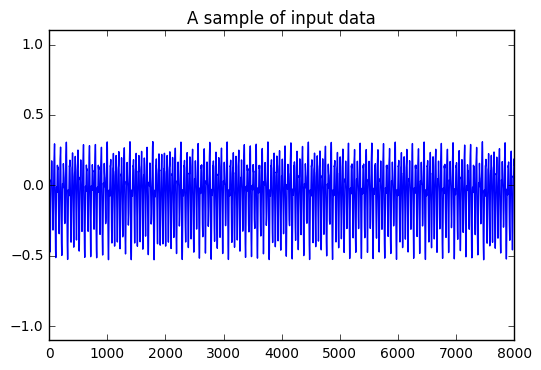

In [5]:
def plot_figure(f) :
    plt.figure(0).clear()
    plt.plot(nw.data[0:int(f)])
    plt.ylim([-1.1,1.1])
    plt.title('A sample of input data')
    
interact(plot_figure, f=FloatSlider(value=2000,min=1000,max=10000,step=1000,continuous_update=False,description='time steps'))

## Calcul du réseau en fonction des paramètres

On commence par générer aléatoirement les poids en entrée <b style="color:#99cc00">W<sub>in</sub></b>, ainsi que les poids <b style="color:#ffcc00">W</b> entre les neurones du réservoir. Ensuite, on crée les matrices des neurones décrits plus tôt : <b style="color:#ffcc00">x</b>, <b style="color:#a7008a">Y<sub>target</sub></b> et <b style="color:#00baff">X</b>.

In [6]:
def initialisation(nw) :

    #Poids
    nw.Win = (np.random.rand(nw.resSize,1+nw.inSize)-0.5) * nw.input_scaling
    nw.W = np.random.rand(nw.resSize,nw.resSize)-0.5 
    
    #Matrices
    #Matrice des états collectés (1,u,x) au cours du temps
    nw.X = np.zeros((1+nw.inSize+nw.resSize,nw.trainLen-nw.initLen))
    #Matrice de sortie cible
    nw.Ytarget = nw.data[None,nw.initLen+1:nw.trainLen+1]

    #Vecteur des états du réservoir
    nw.x = np.zeros((nw.resSize,1))  
    
    return(nw)

On calcule le rayon spectral de la matrice <b style="color:#ffcc00">W</b> des poids du réservoir, qui correspond à la valeur absolue des valeurs propres la plus élevée. Ensuite, on redimensionne les poids en fonction de ce rayon spectral.
Plus le rayon spectral est élevé, plus le système est apte à se souvenir d'entrées plus longues.

In [7]:
def calcul_rayon_spectral(nw):
    print('Calcul du rayon spectral',end=" ")
    rhoW = max(abs(linalg.eig(nw.W)[0]))
    print('effectué.')
    nw.W *= nw.spectral_radius / rhoW
    
    return(nw)

<p style="text-align:justify">On passe ensuite à une phase d'apprentissage, qui va durer un nombre d'itérations défini (<b>trainLen</b>). En entrée, on utilise les données issues du fichier <i>data</i>. A chaque itération, on modifie la valeur de la donnée de chaque neurone du réservoir en fonction des poids <b style="color:#99cc00">W<sub>in</sub></b>. On se sert de la formule suivante :</p>


$$x_{n} = (1-\alpha)x_{n-1} + \alpha \tanh(W_{in}.u_{n-1} + W.x_{n-1})$$


<p style="text-align:justify">Dans cette formule, le $\alpha$ agit comme un facteur de "mémoire" du réseau.
Une fois la période d'initialisation terminée (<b>initLen</b>), on commence à modifier la matrice <b style="color:#00baff">X</b>, qui va collecter les états des neurones durant la simulation : le premier neurone correspond au biais (<b style="color:#99cc00">1</b>), le second à l'entrée (<b style="color:#99cc00">u</b>), et tous les suivants aux neurones du réservoir (la matrice <b style="color:#ffcc00">x</b>) :</p>
$$X_{n} = [1;u_{n};x_{n}]$$

In [8]:
def apprentissage(nw) :
    for t in range(nw.trainLen):
        #Données en entrée, issues de data
        nw.u = nw.data[t]
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.vstack((1,nw.u)) ) + np.dot( nw.W, nw.x ) )
        #Au bout d'un certain temps, on modifie X
        if t >= nw.initLen:
            nw.X[:,t-nw.initLen] = np.vstack((1,nw.u,nw.x))[:,0]
            
    return(nw)

On va maintenant passer à l'entraînement des poids en sortie <b style="color:#ff0000">W<sub>out</sub></b>, en les ajustant en fonction des valeurs des neurones du réservoir (<b style="color:#00baff">X</b>) et des valeurs de sortie cibles (<b style="color:#a7008a">Y<sub>target</sub></b>) :
$$W_{out} = (Y_{target}.X^{T}).(X.X^{T} + reg.I)^{-1}$$


In [20]:
def entrainement_sortie(nw) :
    nw.X_T = nw.X.T
    if nw.reg is not None:
        # Régression de crête (régression linéaire avec régularisation)
        nw.Wout = np.dot(np.dot(nw.Ytarget,nw.X_T), linalg.inv(np.dot(nw.X,nw.X_T) + \
            nw.reg*np.eye(1+nw.inSize+nw.resSize) ) )
    else:
        # Utilisation du pseudo-inverse
        nw.Wout = np.dot(nw.Ytarget, linalg.pinv(nw.X) )
    return(nw)

L'entrainement terminé, on peut maintenant passer au test du réseau.
En mode génératif, on va, à chaque itération, se servir de la sortie précédente pour générer la suivante. En mode prédictif, on va se servir de la donnée réelle afin de tenter de prédire la sortie suivante.

In [21]:
def test(nw) :
    nw.Y = np.zeros((nw.outSize,nw.testLen))
    nw.u = nw.data[nw.trainLen]
    for t in range(nw.testLen):
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.vstack((1,nw.u)) ) + np.dot(nw.W,nw.x ) )
        nw.y = np.dot(nw.Wout, np.vstack((1,nw.u,nw.x)) )
        nw.Y[:,t] = nw.y
        if nw.mode == 'generative':
            #Mode génératif:
            nw.u = nw.y
        elif nw.mode == 'prediction':
            #Mode prédictif:
            nw.u = nw.data[nw.trainLen+t+1] 
        else:
            raise(Exception, "ERREUR: le 'mode' n'a pas été correctement déclaré.")

    return(nw)

In [22]:
def calcul_erreur(nw) :
    # Calcul du MSE pour les premières errorLen itérations
    errorLen = 500
    mse = sum( np.square( nw.data[nw.trainLen+1:nw.trainLen+errorLen+1] - nw.Y[0,0:errorLen] ) ) / errorLen
    print('MSE = ' + str( mse ))
    
    return(nw)

In [23]:
def calcul_reseau(nw) :
    nw = initialisation(nw)
    nw = calcul_rayon_spectral(nw)
    nw = apprentissage(nw)
    nw = entrainement_sortie(nw)
    nw = test(nw) 
    nw = calcul_erreur(nw)
    return(nw)

## Définition des paramètres du réseau

Vous pouvez ici modifier les différents paramètres du réseau en déplaçant les curseurs, puis en cliquant sur Valider. Cela affectera tous les graphiques que vous pourrez afficher par la suite.

In [39]:
select_mode = ToggleButtons(description='Mode:',
    options=['prediction', 'generative'])
var1 = FloatSlider(value=300, min=0, max=1000, step=1, description='resSize')
var2 = FloatSlider(value=100, min=0, max=2000, step=1, description='initLen')
var3 = FloatSlider(value=2000, min=0, max=5000, step=1, description='trainLen')
var4 = FloatSlider(value=2000, min=0, max=5000, step=1, description='testLen')
var5 = FloatSlider(value=1.25, min=0, max=10, step=0.05, description='spectral radius')
var6 = FloatSlider(value=0.3, min=0, max=1, step=0.01, description='leak rate')
valid = Button(description='Valider')

def record_values(_) :
    clear_output()
    nw.mode=select_mode.value
    nw.resSize=int(var1.value)
    nw.initLen=int(var2.value)
    nw.trainLen=int(var3.value)
    nw.testLen=int(var4.value)
    nw.spectral_radius=float(var5.value)
    nw.a=float(var6.value)
    print("InitLen:", nw.initLen, "TrainLen:", nw.trainLen, "TestLen:", nw.testLen) 
    print("ResSize:", nw.resSize, "Spectral Radius:", nw.spectral_radius, "Leak Rate:", nw.a)
    calcul_reseau(nw)
    return(nw)

display(select_mode)
display(var1)
display(var2)
display(var3)
display(var4)
display(var5)
display(var6)
display(valid)

valid.on_click(record_values)

InitLen: 100 TrainLen: 2000 TestLen: 5000
ResSize: 300 Spectral Radius: 2.6 Leak Rate: 0.3
Calcul du rayon spectral effectué.
MSE = 20.2787803661


## Graphique 1 : Comparaison entre sorties attendues et sorties estimées

In [42]:
var7 = FloatSlider(value=2000,min=10,max=10000,step=10,description='time steps')
valid = Button(description='Valider')
        
def trace_graph1(_) :
    clear_output()
    f=int(var7.value)
    plt.figure(1).clear()
    plt.plot( nw.data[nw.trainLen+1:nw.trainLen+f+1], 'g' )
    plt.plot( nw.Y.T[0:f], 'b' )
    plt.title('Target and generated signals $y(n)$ starting at $n=0$')
    if nw.mode == 'generative':
        plt.legend(['Target signal', 'Free-running predicted signal'])
    elif nw.mode == 'prediction':
        plt.legend(['Target signal', 'Predicted signal'])
    
valid.on_click(trace_graph1)
    
display(var7)
display(valid)

## Graphique 2 : Différence entre sorties attendues et sorties estimées

In [36]:
var8 = FloatSlider(value=2000,min=10,max=nw.testLen,step=10,description='time steps')
var9 = FloatSlider(value=0.2,min=0.001,max=10,step=0.001,description='amplitude')
valid = Button(description='Valider')
        
def trace_graph2(_) :
    clear_output()
    f=int(var8.value)
    amp=float(var9.value)
    plt.figure(2).clear()
    plt.ylim([-amp,amp])
    plt.plot(nw.data[nw.trainLen+1:nw.trainLen+f+1]-nw.Y[0][0:f], 'g' )
    print(nw.Y[0].shape)
    plt.title('Target and predicted signal difference through time')
    if nw.mode == 'generative':
        plt.legend(['Target signal', 'Free-running predicted signal'])
    elif nw.mode == 'prediction':
        plt.legend(['Target signal', 'Predicted signal'])
    
valid.on_click(trace_graph2)
    
display(var8)
display(var9)
display(valid)

## Graphique 3 : Affichage des activations des neurones du réservoir (total)

(302, 1900)


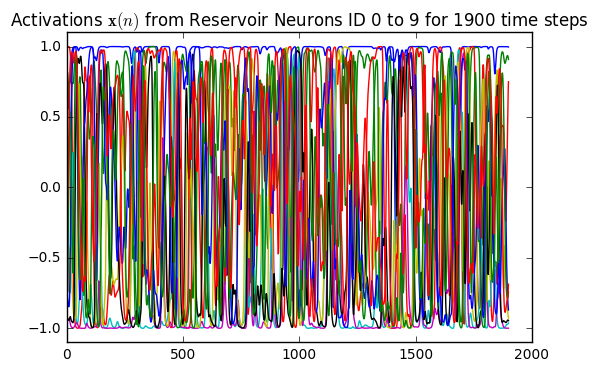

In [43]:
var10 = FloatSlider(value=2000,min=10,max=nw.trainLen-nw.initLen,step=10,description='time steps')
var11 = FloatSlider(value=10, min=1, max=nw.resSize, step=1, description='nombre de neurones')
valid = Button(description='Valider')

def trace_graph3(_) :
    clear_output()
    f=int(var10.value)
    nb=int(var11.value)
    plt.figure(3).clear()
    plt.plot( nw.X[2:2+nb,0:f].T )
    print(nw.X.shape)
    plt.ylim([-1.1,1.1])
    plt.title('Activations $\mathbf{x}(n)$ from Reservoir Neurons ID 0 to '+str(nb-1)+' for '+str(f)+' time steps')
    
valid.on_click(trace_graph3)
    
display(var10)
display(var11)
display(valid)

## Graphique 4 : Affichage des activations d'un neurone unique du réservoir

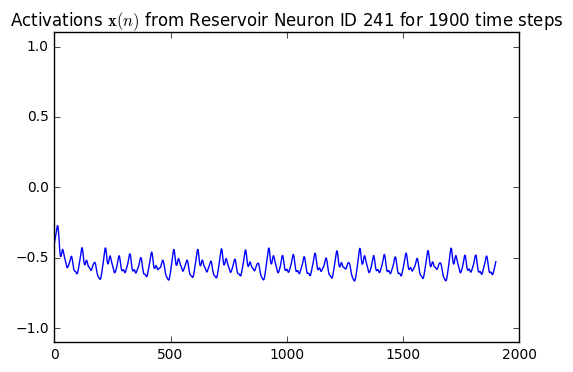

In [38]:
var12 = FloatSlider(value=2000,min=10,max=nw.trainLen-nw.initLen,step=10,description='time steps')
var13 = FloatSlider(value=2, min=0, max=nw.resSize-1, step=1, description='ID du neurone')
valid = Button(description='Valider')

def trace_graph4(_) :
    clear_output()
    f=int(var12.value)
    num=int(var13.value)
    plt.figure(4).clear()
    plt.plot( nw.X[2+num,:f].T )
    plt.ylim([-1.1,1.1])
    plt.title('Activations $\mathbf{x}(n)$ from Reservoir Neuron ID '+str(num)+' for '+str(f)+' time steps')

valid.on_click(trace_graph4)

display(var12)
display(var13)
display(valid)

## Graphique 5 : Poids de sortie à la fin de la simulation

In [19]:
valid = Button(description='Afficher')

def trace_graph5(_) :
    clear_output()
    plt.figure(5).clear()
    plt.bar( range(1+nw.inSize+nw.resSize), nw.Wout.T )
    plt.title('Output weights $\mathbf{W}^{out}$')

valid.on_click(trace_graph5)

display(valid)